In [77]:
# for automatic reloading of modules (quick debugging)
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
from utils.dataset import TaxiDataset
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
tdf = TaxiDataset()

In [79]:
df = pr.load_taxi_data(month = 1, year = 2023, vehicle_type = 'yellow')

In [80]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [82]:
df.dropna().isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

In [7]:
# processing (minimal right now)
vehicle_type = 'yellow'
if vehicle_type == 'yellow':
    # split datetime into data and time
    df.rename(
        columns = {'tpep_pickup_datetime': 'pickup_datetime',
                'tpep_dropoff_datetime': 'dropoff_datetime'}, 
        inplace = True
    )
else:
    raise ValueError('Only yellow taxi data is supported at the moment')

# remove rows with year not equal to 2023 and within January
df = df[(df.pickup_datetime.dt.year == 2023) & (df.pickup_datetime.dt.month == 1)]
df.pickup_datetime.sort_values().head()

2995098   2023-01-01 00:00:00
3497      2023-01-01 00:00:05
2506      2023-01-01 00:00:06
3499      2023-01-01 00:00:08
4475      2023-01-01 00:00:09
Name: pickup_datetime, dtype: datetime64[us]

In [8]:
# want to create dataframe by routes, check that this approach will restore a dataframe binning only by pickup location

In [9]:
ts_pu = df.set_index('pickup_datetime').groupby(['PULocationID', pd.Grouper(freq='h')]).size().to_frame('counts')
ts = df.set_index('pickup_datetime').groupby(['PULocationID', 'DOLocationID', pd.Grouper(freq='h')]).size().to_frame('counts')

In [10]:
# select rows with locationid 79
ts = ts.reset_index()
ts_pu = ts_pu.reset_index()

In [11]:
ts_79 = ts[ts['PULocationID'] == 79]
ts_pu_79 = ts_pu[ts_pu['PULocationID'] == 79]

In [12]:
ts_79

,PULocationID,DOLocationID,pickup_datetime,counts
159972,79,1,2023-01-01 08:00:00,1
159973,79,1,2023-01-01 10:00:00,1
159974,79,1,2023-01-02 05:00:00,1
159975,79,1,2023-01-02 07:00:00,1
159976,79,1,2023-01-02 14:00:00,1
...,...,...,...,...
188146,79,265,2023-01-28 02:00:00,4
188147,79,265,2023-01-28 04:00:00,1
188148,79,265,2023-01-29 00:00:00,1
188149,79,265,2023-01-29 02:00:00,2


In [13]:
ts_79_pu = ts_79.groupby(['pickup_datetime', 'PULocationID']).sum().reset_index().drop(columns = 'PULocationID')

<Axes: xlabel='pickup_datetime'>

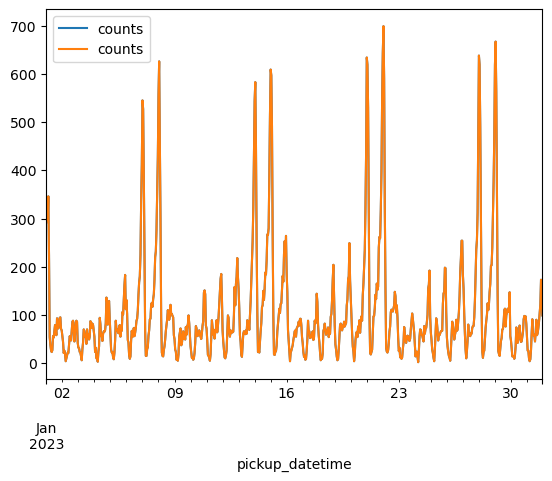

In [14]:
# remove DOLocationID column from ts_p
ts_pu_79.plot(x = 'pickup_datetime', y = 'counts')
ts_79_pu.plot(x = 'pickup_datetime', y = 'counts', ax = plt.gca())

In [15]:
# create a dataframe with route information (both pickup and dropoff location)
ts = df.set_index('pickup_datetime').groupby(['PULocationID', 'DOLocationID', pd.Grouper(freq='h')]).size()
ts.head()

PULocationID  DOLocationID  pickup_datetime    
1             1             2023-01-01 05:00:00    1
                            2023-01-01 08:00:00    1
                            2023-01-01 11:00:00    1
                            2023-01-01 12:00:00    3
                            2023-01-01 13:00:00    3
dtype: int64

In [16]:
ts = ts.to_frame(name = 'counts') # convert to dataframe 
ts.head()

counts
PULocationID DOLocationID pickup_datetime            
1            1            2023-01-01 05:00:00       1
                          2023-01-01 08:00:00       1
                          2023-01-01 11:00:00       1
                          2023-01-01 12:00:00       3
                          2023-01-01 13:00:00       3

In [17]:
ts = ts.unstack(level=[0,1]).fillna(0) # unstack to obtain missing hours as NaNs, fill missing rides with 0
ts.head()

counts                                               ...  \
PULocationID           1                                                 ...   
DOLocationID           1    6    21   52   97   132  138  172  231  236  ...   
pickup_datetime                                                          ...   
2023-01-01 00:00:00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-01-01 01:00:00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-01-01 02:00:00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-01-01 03:00:00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2023-01-01 04:00:00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                                                                       
PULocationID         265                                               
DOLocationID         238  242  243  244  246  256  259  262  264  265  
pickup_datetime                                                        
2023-01-01 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  
2023-01-01 01:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  9.0  
2023-01-01 02:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  7.0  
2023-01-01 03:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  8.0  
2023-01-01 04:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  

[5 rows x 22754 columns]

In [18]:
ts.index = ts.index.tz_localize('America/New_York', ambiguous = True) # need to localize timezone for time to appear
ts.head()

counts                                               \
PULocationID                 1                                                  
DOLocationID                 1    6    21   52   97   132  138  172  231  236   
pickup_datetime                                                                 
2023-01-01 00:00:00-05:00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-01-01 01:00:00-05:00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-01-01 02:00:00-05:00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-01-01 03:00:00-05:00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-01-01 04:00:00-05:00    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                           ...                                               \
PULocationID               ...  265                                           
DOLocationID               ...  238  242  243  244  246  256  259  262  264   
pickup_datetime            ...                                                
2023-01-01 00:00:00-05:00  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-01-01 01:00:00-05:00  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
2023-01-01 02:00:00-05:00  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2023-01-01 03:00:00-05:00  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-01-01 04:00:00-05:00  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                
PULocationID                    
DOLocationID               265  
pickup_datetime                 
2023-01-01 00:00:00-05:00  4.0  
2023-01-01 01:00:00-05:00  9.0  
2023-01-01 02:00:00-05:00  7.0  
2023-01-01 03:00:00-05:00  8.0  
2023-01-01 04:00:00-05:00  4.0  

[5 rows x 22754 columns]

In [19]:
# undo stack
ts = ts.stack(level = [1,2], future_stack = True)

In [20]:
ts = ts.reset_index() # remove the stacked structure to have standard dataframe with rows and columns only

In [21]:
ts

,pickup_datetime,PULocationID,DOLocationID,counts
0,2023-01-01 00:00:00-05:00,1,1,0.0
1,2023-01-01 00:00:00-05:00,1,6,0.0
2,2023-01-01 00:00:00-05:00,1,21,0.0
3,2023-01-01 00:00:00-05:00,1,52,0.0
4,2023-01-01 00:00:00-05:00,1,97,0.0
...,...,...,...,...
16928971,2023-01-31 23:00:00-05:00,265,256,0.0
16928972,2023-01-31 23:00:00-05:00,265,259,0.0
16928973,2023-01-31 23:00:00-05:00,265,262,0.0
16928974,2023-01-31 23:00:00-05:00,265,264,0.0


In [22]:
ts.sort_values(by = ['pickup_datetime', 'PULocationID', 'DOLocationID']) # sort by location and time

,pickup_datetime,PULocationID,DOLocationID,counts
0,2023-01-01 00:00:00-05:00,1,1,0.0
1,2023-01-01 00:00:00-05:00,1,6,0.0
2,2023-01-01 00:00:00-05:00,1,21,0.0
3,2023-01-01 00:00:00-05:00,1,52,0.0
4,2023-01-01 00:00:00-05:00,1,97,0.0
...,...,...,...,...
16928971,2023-01-31 23:00:00-05:00,265,256,0.0
16928972,2023-01-31 23:00:00-05:00,265,259,0.0
16928973,2023-01-31 23:00:00-05:00,265,262,0.0
16928974,2023-01-31 23:00:00-05:00,265,264,0.0


<Axes: xlabel='pickup_datetime'>

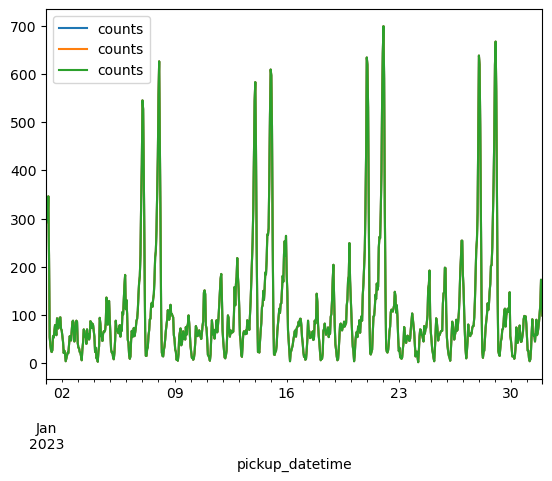

In [23]:
ts_79_aug = ts[ts['PULocationID'] == 79].groupby(['pickup_datetime', 'PULocationID']).sum().reset_index().drop(columns = 'PULocationID')
ts_79_aug.plot(x = 'pickup_datetime', y = 'counts')
ts_pu_79.plot(x = 'pickup_datetime', y = 'counts', ax = plt.gca())
ts_79_pu.plot(x = 'pickup_datetime', y = 'counts', ax = plt.gca())

In [24]:
# test updated bin_data
ts_quick = pr.bin_data(df, by_value = ['PULocationID', 'DOLocationID'])

In [25]:
ts_quick_79_aug = ts_quick[ts_quick['PULocationID'] == 79].groupby(['pickup_datetime', 'PULocationID']).sum().reset_index().drop(columns = 'PULocationID')

<Axes: xlabel='pickup_datetime'>

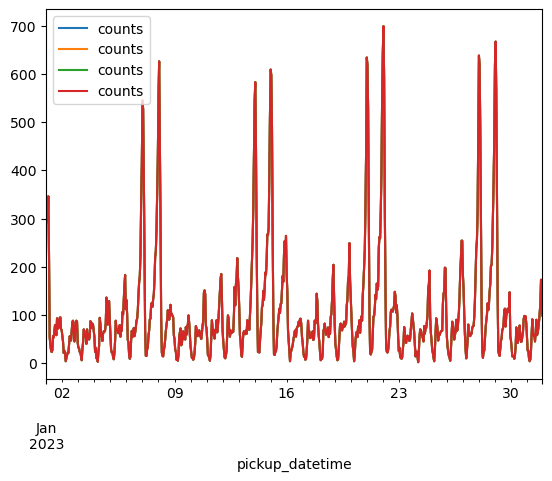

In [26]:
# check that all methods are consistent
ts_79_aug = ts[ts['PULocationID'] == 79].groupby(['pickup_datetime', 'PULocationID']).sum().reset_index().drop(columns = 'PULocationID')
ts_79_aug.plot(x = 'pickup_datetime', y = 'counts')
ts_pu_79.plot(x = 'pickup_datetime', y = 'counts', ax = plt.gca())
ts_79_pu.plot(x = 'pickup_datetime', y = 'counts', ax = plt.gca())
ts_quick_79_aug.plot(x = 'pickup_datetime', y = 'counts', ax = plt.gca())

(-2.0, 2.6020599913279625)

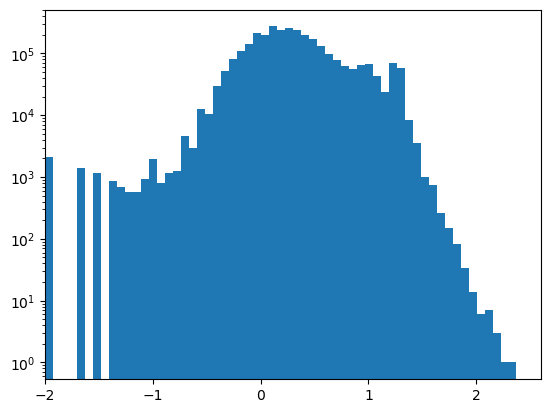

In [61]:
df_local = df[df['trip_distance'] > 0.]
plt.hist(np.log10(np.abs(df_local['trip_distance'])), bins = 100)
plt.yscale('log')
plt.xlim([-2, np.log10(400)])

In [63]:
# do the same but include counts and average fare, tip, etc.
df = df[(df['trip_distance'] > 0.) & (df['trip_distance'] < 500.)]
gb = df.set_index('pickup_datetime').groupby(['PULocationID', 'DOLocationID', pd.Grouper(freq='h')])
ts = gb.size().to_frame('counts')
ts = (ts
    .join(gb.agg({'total_amount': 'mean'}))
    .join(gb.agg({'tip_amount': 'mean'}))
    .join(gb.agg({'fare_amount': 'mean'}))
    .join(gb.agg({'trip_distance': 'mean'}))
)
ts
# ts = df.set_index('pickup_datetime').groupby(['PULocationID', 'DOLocationID', pd.Grouper(freq='h')]).agg({'total_amount': 'mean', 'tip_amount': 'mean', 'fare_amount': 'mean', 'trip_distance': 'mean'})

# ts = df.set_index('pickup_datetime').groupby(['PULocationID', 'DOLocationID', pd.Grouper(freq='h')]).agg({'total_amount': 'mean', 'tip_amount': 'mean', 'fare_amount': 'mean', 'trip_distance': 'mean'})
# ts.head()

counts  total_amount  \
PULocationID DOLocationID pickup_datetime                             
1            1            2023-01-01 12:00:00       1    276.000000   
                          2023-01-01 13:00:00       1    138.450000   
                          2023-01-01 14:00:00       1    139.200000   
                          2023-01-01 15:00:00       2     42.000000   
                          2023-01-01 16:00:00       1    138.700000   
...                                               ...           ...   
265          265          2023-01-31 16:00:00       1    103.860000   
                          2023-01-31 17:00:00       2    368.525000   
                          2023-01-31 21:00:00       1     97.150000   
                          2023-01-31 22:00:00       1    121.100000   
                          2023-01-31 23:00:00       3    163.433333   

                                               tip_amount  fare_amount  \
PULocationID DOLocationID pickup_datetime                                
1            1            2023-01-01 12:00:00   25.000000   250.000000   
                          2023-01-01 13:00:00    0.000000   122.700000   
                          2023-01-01 14:00:00   23.200000   115.000000   
                          2023-01-01 15:00:00    0.000000    41.000000   
                          2023-01-01 16:00:00    0.000000   104.000000   
...                                                   ...          ...   
265          265          2023-01-31 16:00:00   17.310000    65.300000   
                          2023-01-31 17:00:00   45.125000   320.900000   
                          2023-01-31 21:00:00   16.150000    80.000000   
                          2023-01-31 22:00:00    0.100000   120.000000   
                          2023-01-31 23:00:00   18.616667   139.066667   

                                               trip_distance  
PULocationID DOLocationID pickup_datetime                     
1            1            2023-01-01 12:00:00       0.010000  
                          2023-01-01 13:00:00      17.710000  
                          2023-01-01 14:00:00       1.200000  
                          2023-01-01 15:00:00       0.125000  
                          2023-01-01 16:00:00       0.100000  
...                                                      ...  
265          265          2023-01-31 16:00:00      16.550000  
                          2023-01-31 17:00:00      25.215000  
                          2023-01-31 21:00:00      10.500000  
                          2023-01-31 22:00:00       0.600000  
                          2023-01-31 23:00:00      10.786667  

[1141893 rows x 5 columns]

In [64]:
ts = ts.unstack(level=[0,1]).fillna(0) # unstack to obtain missing hours as NaNs, fill missing rides with 0
ts.index = ts.index.tz_localize('America/New_York', ambiguous = True).fillna(0) # need to localize timezone for time to appear
ts = ts.stack(level = [1,2], future_stack = True).fillna(0) # stack again to have a single index
ts = ts.reset_index() # remove the stacked structure to have standard dataframe with rows and columns only
ts.sort_values(by = ['pickup_datetime', 'PULocationID', 'DOLocationID']) # sort by location and time
ts

,pickup_datetime,PULocationID,DOLocationID,counts,total_amount,tip_amount,fare_amount,trip_distance
0,2023-01-01 00:00:00-05:00,1,1,0.0,0.000000,0.000000,0.000000,0.000000
1,2023-01-01 00:00:00-05:00,1,6,0.0,0.000000,0.000000,0.000000,0.000000
2,2023-01-01 00:00:00-05:00,1,21,0.0,0.000000,0.000000,0.000000,0.000000
3,2023-01-01 00:00:00-05:00,1,52,0.0,0.000000,0.000000,0.000000,0.000000
4,2023-01-01 00:00:00-05:00,1,97,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
16106107,2023-01-31 23:00:00-05:00,265,256,0.0,0.000000,0.000000,0.000000,0.000000
16106108,2023-01-31 23:00:00-05:00,265,259,0.0,0.000000,0.000000,0.000000,0.000000
16106109,2023-01-31 23:00:00-05:00,265,262,0.0,0.000000,0.000000,0.000000,0.000000
16106110,2023-01-31 23:00:00-05:00,265,264,0.0,0.000000,0.000000,0.000000,0.000000


In [65]:
# compute mean of total amount in locationid 79 and hour 0 from the dataframe
df[(df['PULocationID'] == 79) & (df['pickup_datetime'].dt.hour == 0)]['total_amount'].mean()

ts[ts['PULocationID'] == 79]

,pickup_datetime,PULocationID,DOLocationID,counts,total_amount,tip_amount,fare_amount,trip_distance
5559,2023-01-01 00:00:00-05:00,79,1,0.0,0.000,0.000,0.00,0.000
5560,2023-01-01 00:00:00-05:00,79,4,4.0,13.035,1.185,6.85,0.775
5561,2023-01-01 00:00:00-05:00,79,7,2.0,41.100,6.850,29.25,5.910
5562,2023-01-01 00:00:00-05:00,79,8,0.0,0.000,0.000,0.00,0.000
5563,2023-01-01 00:00:00-05:00,79,9,0.0,0.000,0.000,0.00,0.000
...,...,...,...,...,...,...,...,...
16090236,2023-01-31 23:00:00-05:00,79,261,1.0,29.200,5.800,18.40,3.900
16090237,2023-01-31 23:00:00-05:00,79,262,1.0,26.910,3.510,18.40,4.250
16090238,2023-01-31 23:00:00-05:00,79,263,0.0,0.000,0.000,0.00,0.000
16090239,2023-01-31 23:00:00-05:00,79,264,0.0,0.000,0.000,0.00,0.000


<Axes: xlabel='pickup_datetime'>

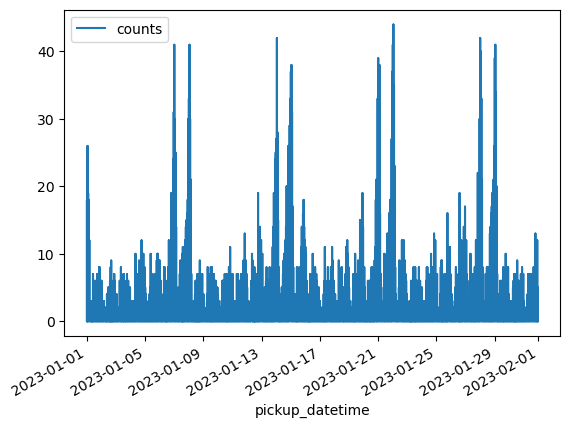

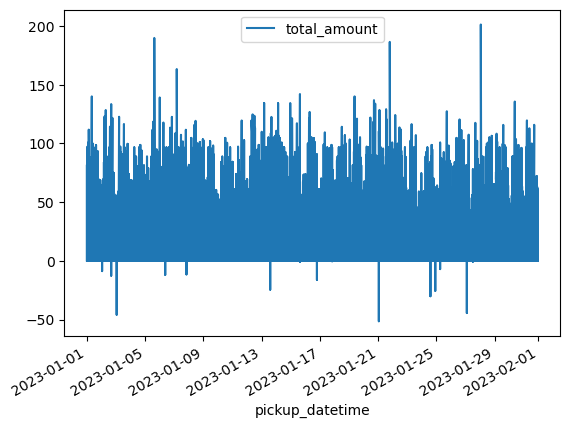

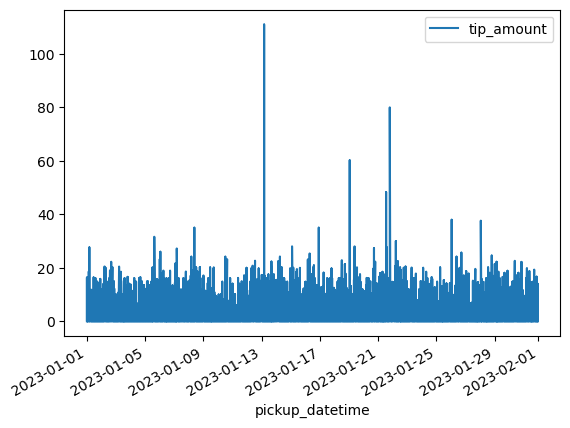

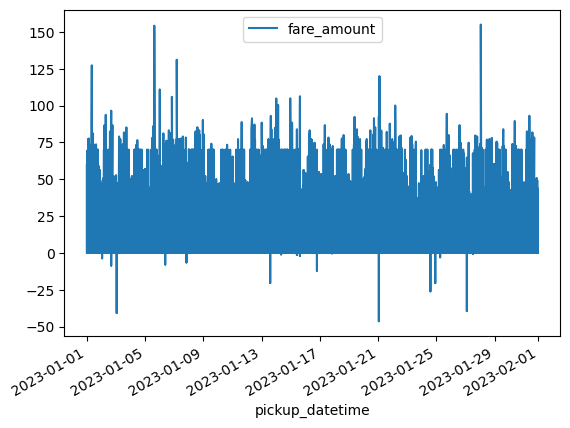

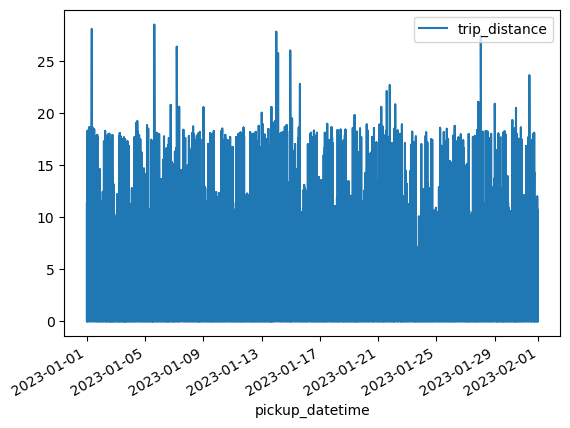

In [66]:
ts_79_full = ts[ts['PULocationID'] == 79]
ts_79_full.plot(x = 'pickup_datetime', y = 'counts')
ts_79_full.plot(x = 'pickup_datetime', y = 'total_amount')
ts_79_full.plot(x = 'pickup_datetime', y = 'tip_amount')
ts_79_full.plot(x = 'pickup_datetime', y = 'fare_amount')
ts_79_full.plot(x = 'pickup_datetime', y = 'trip_distance')

In [67]:
# check for correlation between counts and tips
ts_79_full[['counts', 'tip_amount']].corr()

,counts,tip_amount
counts,1.000000,0.373706
tip_amount,0.373706,1.000000


/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


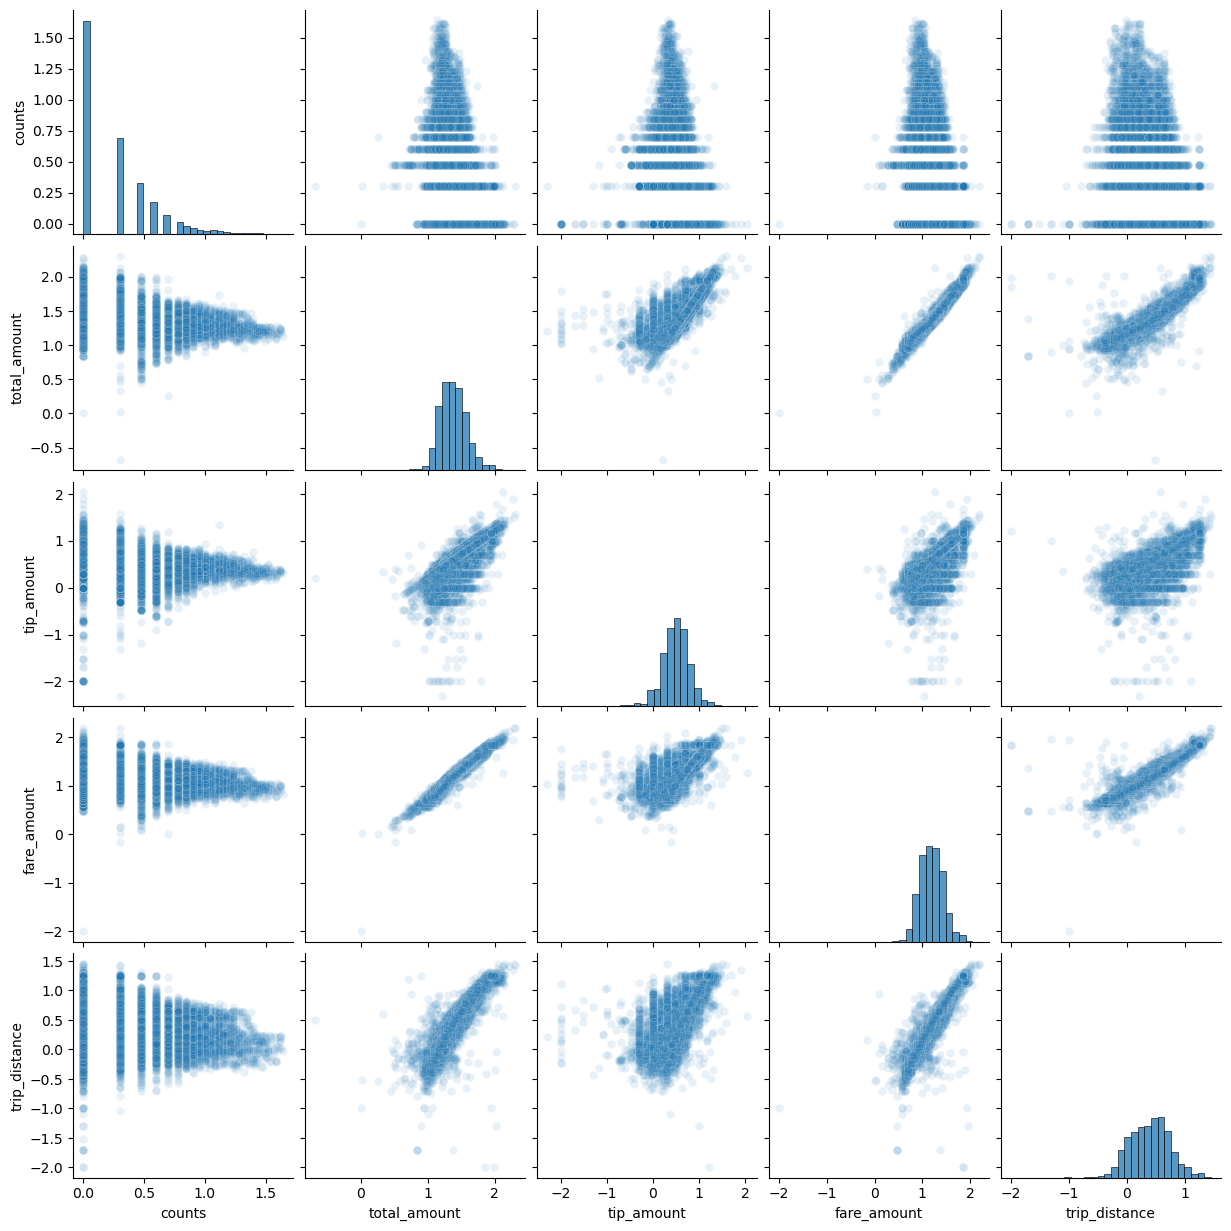

In [76]:
features = ['counts', 'total_amount', 'tip_amount', 'fare_amount', 'trip_distance']
sns.pairplot(np.log10(ts_79_full[features]), diag_kws = {'bins': 30}, plot_kws = {'alpha': 0.1})

In [90]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


(array([4.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.57000e+02,
        1.50000e+01, 2.40000e+01, 2.50000e+01, 5.00000e+01, 6.50000e+01,
        1.60000e+02, 3.75900e+03, 4.24600e+03, 1.83960e+04, 1.03120e+05,
        3.47193e+05, 6.30711e+05, 6.48822e+05, 4.74487e+05, 2.82020e+05,
        1.47326e+05, 8.10080e+04, 9.66840e+04, 9.94320e+04, 8.99940e+04,
        8.11100e+03, 2.64000e+03, 1.41000e+03, 5.89000e+02, 2.68000e+02,
        1.14000e+02, 4.70000e+01, 1.10000e+01, 2.00000e+00, 2.00000e+00]),
 array([-2.        , -1.89864074, -1.79728148, -1.69592221, -1.59456295,
        -1.49320369, -1.39184443, -1.29048517, -1.18912591, -1.08776664,
        -0.98640738, -0.88504812, -0.78368886, -0.6823296 , -0.58097033,
        -0.47961107, -0.37825181, -0.27689255, -0

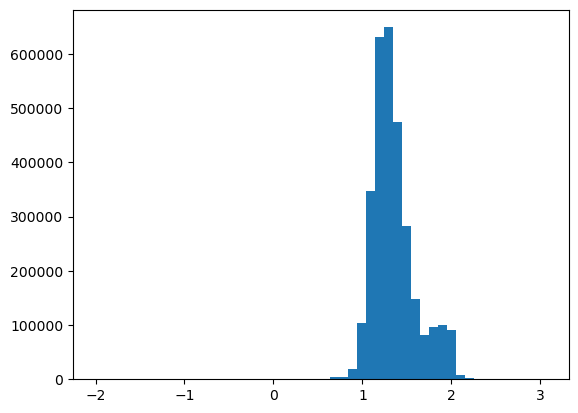

In [89]:
# check for negative values in the dataframe
df_pos = df[df['total_amount'] > 0.]
plt.hist(np.log10(df_pos['total_amount']), bins = 50)

In [98]:
df_pos.tip_amount.sort_values()[-1::-1]

2543923    380.80
1440494    222.21
13824      211.50
2516470    202.00
2759852    201.65
            ...  
457939       0.00
984597       0.00
3030890     -3.00
3045965     -3.79
3062460     -5.78
Name: tip_amount, Length: 3040994, dtype: float64

: 